In [5]:
import numpy as np
import pandas as pd
from scipy.stats import entropy
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('..')

from lib import *

In [6]:
df_t = load_iedb_tcellepitopes(human_only=True)
df_b = load_iedb_bcellepitopes(human_only=True)

# Qualitative exploration of database content

In [36]:
df_t.columns.get_level_values(0).unique()

Index(['Reference', 'Epitope', 'Related Object', 'Host', '1st in vivo Process',
       '2nd in vivo Process', 'In Vitro Process', 'Adoptive Transfer',
       'Immunization Comments', 'Assay', 'Effector Cells', 'TCR',
       'Antigen Presenting Cells', 'MHC', 'Assay Antigen', 'Assay Comments'],
      dtype='object')

In [52]:
for df in [df_t, df_b]:
    print(df['Epitope', 'Parent Species'].value_counts().head(10))
    print()

Mycobacterium tuberculosis    27327
Vaccinia virus                22916
Blattella germanica           17120
Homo sapiens                  16583
Hepacivirus C                 12775
Phleum pratense               12763
Burkholderia pseudomallei     10286
Dengue virus                   6337
Human betaherpesvirus 5        5519
Human gammaherpesvirus 4       4663
Name: (Epitope, Parent Species), dtype: int64

Trypanosoma cruzi           174006
Homo sapiens                 39988
Onchocerca volvulus          13071
Streptococcus pyogenes        7167
Human gammaherpesvirus 4      7106
Hepacivirus C                 6220
Arachis hypogaea              2961
Bos taurus                    2280
Plasmodium falciparum         1869
Triticum aestivum             1827
Name: (Epitope, Parent Species), dtype: int64



In [58]:
df_t['1st in vivo Process']['Process Type'].value_counts().head(10)

Occurrence of infectious disease                                                   55037
Occurrence of allergy                                                              43646
Administration in vivo                                                             31095
Environmental exposure to endemic/ubiquitous agent without evidence for disease    26519
Exposure with existing immune reactivity without evidence for disease              24249
No immunization                                                                    18087
Occurrence of autoimmune disease                                                    9317
Exposure without evidence for disease                                               1082
Occurrence of cancer                                                                1063
Documented exposure without evidence for disease                                    1030
Name: Process Type, dtype: int64

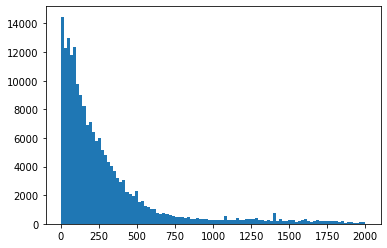

In [50]:
plt.hist(df_t['Epitope']['Starting Position'], bins=np.linspace(0, 2000, 100));

In [32]:
df_t['Effector Cells']['Cell Type'].value_counts().head(5)

PBMC           123810
T cell CD4+     48290
T cell CD8+     23570
T cell          13151
T cell CD8-      1334
Name: Cell Type, dtype: int64

In [9]:
df_t['Assay']['Assay Group'].value_counts().head(5)

IFNg release           129267
proliferation           26285
IL-5 release            14815
qualitative binding      7704
IL-10 release            7654
Name: Assay Group, dtype: int64

In [4]:
len(df_b[df_b['Epitope', 'Parent Species'].str.contains('Plasmodium falciparum', na=False)]['Epitope', 'Description'].unique())

984

In [5]:
epi_t = df_t['Epitope', 'Description']
epi_b = df_b['Epitope', 'Description']

In [8]:
k = 2
dfhuman = counter_to_df(count_kmers_proteome(human, k))
dfiedb_t = counter_to_df(count_kmers_iterable(epi_t, k))
dfiedb_b = counter_to_df(count_kmers_iterable(epi_b, k))
for df in [dfhuman, dfiedb_t, dfiedb_b]:
    df.sort_values('seq', inplace=True)
dfm = pd.DataFrame.from_dict(dict(seq=list(dfhuman['seq']),
                   human=list(dfhuman['freq']),
                   iedb_t=list(dfiedb_t['freq']),
                   iedb_b=list(dfiedb_b['freq'])))

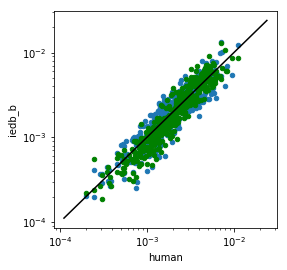

In [9]:
fig, ax = plt.subplots(figsize=(4, 4))
x = np.logspace(np.log10(dfm['human'].min())-0.25, np.log10(dfm['iedb_t'].max())+0.25)
plt.plot(x, x, 'k')
dfm.plot('human', 'iedb_t', kind='scatter', logx=True, logy=True, ax=ax)
dfm.plot('human', 'iedb_b', kind='scatter', logx=True, logy=True, ax=ax, color='g')
#ax.set_xlim(2e-7, 5e-3)
#ax.set_ylim(2e-7, 5e-3)

In [11]:
calc_jsd(dfm['iedb_t'], dfm['human']), calc_jsd(dfm['iedb_b'], dfm['human'])

(0.012649310187548942, 0.008761949030750435)

In [7]:
dfm['fold_t'] = dfm['iedb_t']/dfm['human']
dfm['fold_b'] = dfm['iedb_b']/dfm['human']

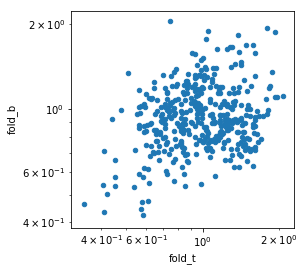

In [8]:
fig, ax = plt.subplots(figsize=(4, 4))
dfm.plot('fold_t', 'fold_b', kind='scatter', ax=ax)
ax.set_yscale('log')
ax.set_xscale('log')

In [9]:
scipy.stats.spearmanr(dfm['fold_t'], dfm['fold_b']), np.corrcoef(np.log(dfm['fold_t']), np.log(dfm['fold_b']))[1, 0]

(SpearmanrResult(correlation=0.15776179851124067, pvalue=0.0015497359624458218),
 0.26492549779006813)

In [10]:
dfm.sort_values('fold_t')

,seq,human,iedb_t,iedb_b,fold_t,fold_b
121,HC,0.000736,0.000252,0.000340,0.341796,0.461337
61,EC,0.001489,0.000604,0.000802,0.405794,0.538783
21,CC,0.000730,0.000299,0.000522,0.408944,0.714381
33,CQ,0.001101,0.000451,0.000476,0.409735,0.432888
261,QC,0.000953,0.000402,0.000479,0.422139,0.502471
263,QE,0.004019,0.001775,0.003733,0.441632,0.928780
23,CE,0.001289,0.000582,0.000744,0.451120,0.576944
301,SC,0.001925,0.000874,0.001035,0.454076,0.537641
34,CR,0.001326,0.000602,0.000876,0.454158,0.660597
252,PP,0.006179,0.002942,0.006150,0.476095,0.995293


In [68]:
epitope_proteins = [s.split('/')[-1] for s in df_t[df_t['Epitope', 'Organism Name'] == 'Plasmodium falciparum']['Epitope', 'Parent Protein IRI'].unique() if type(s) == type('')]
epitope_proteins

['Q7K740',
 'Q76NM2',
 'Q8I0U6',
 'O96275',
 'Q8IIF0',
 'Q8IC44',
 'Q6ZMA7',
 'P50498',
 'Q8I0U8',
 'Q8IB24',
 'Q8IHN4',
 'Q9TY95',
 'Q8I5D2',
 'Q8ID94',
 'Q8ILR9',
 'Q8IBE8',
 'Q8I484',
 'Q8ILZ1',
 'Q8IEU2',
 'Q8I562',
 'Q7KWJ2',
 'Q7KQK5',
 'Q7KQL9',
 'Q7K6A5',
 'Q9TY99',
 'Q03400',
 'Q8IJ55',
 'Q8IJP8',
 'Q8IDZ5',
 'Q8IJY8',
 'Q8I639']

In [62]:
proteomes = load_proteomes()
malaria = datadir + proteomes.loc['Malaria']['path']

In [70]:
epitope_proteins_aa = [s for h, s in fasta_iter(malaria, returnheader=True) if iscontained(h, epitope_proteins)]

In [78]:
df_epi = counter_to_df(count_kmers_iterable(epitope_proteins_aa, k=1, clean=True))

In [79]:
df_all = counter_to_df(count_kmers_iterable(fasta_iter(malaria, returnheader=False), k=1, clean=True))

In [82]:
dfm = df_epi.merge(df_all, on='seq')

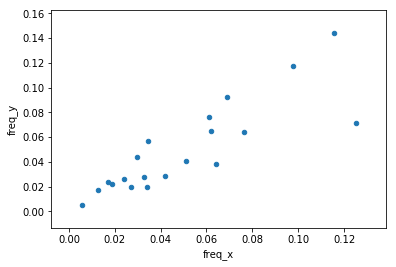

In [87]:
dfm.plot(x='freq_x', y='freq_y', kind='scatter')